# Robot Base Floor
<img src="../Kaggle/CareerCon 2019 - Help Navigate Robots/pic.jpg" />

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from bayes_opt import BayesianOptimization
%matplotlib inline

# Import Data

In [2]:
Submission=pd.read_csv('.\\Kaggle\\CareerCon 2019 - Help Navigate Robots\\data\\sample_submission.csv')
train_X = pd.read_csv('.\\Kaggle\\CareerCon 2019 - Help Navigate Robots\\data\\X_train.csv').iloc[:,3:].values.reshape(-1,128,10)
test_X  = pd.read_csv('.\\Kaggle\\CareerCon 2019 - Help Navigate Robots\\data\\X_test.csv' ).iloc[:,3:].values.reshape(-1,128,10)
print('train_X shape:', train_X.shape, ', test_X shape:', test_X.shape)
df_train_y = pd.read_csv('.\\Kaggle\\CareerCon 2019 - Help Navigate Robots\\data\\Y_train.csv')

# build a dict to convert surface names into numbers
surface_names = df_train_y['surface'].unique()
num_surfaces = len(surface_names)
surface_to_numeric = dict(zip(surface_names, range(num_surfaces)))
print('Convert to numbers: ', surface_to_numeric)

# y and group data as numeric values:
train_y = df_train_y['surface'].replace(surface_to_numeric).values
train_group = df_train_y['group_id'].values

train_X shape: (3810, 128, 10) , test_X shape: (3816, 128, 10)
Convert to numbers:  {'fine_concrete': 0, 'concrete': 1, 'soft_tiles': 2, 'tiled': 3, 'soft_pvc': 4, 'hard_tiles_large_space': 5, 'carpet': 6, 'hard_tiles': 7, 'wood': 8}


In [3]:
train_group

array([13, 31, 20, ..., 48, 54, 56], dtype=int64)

In [4]:
len(pd.Series(train_group).unique())

73

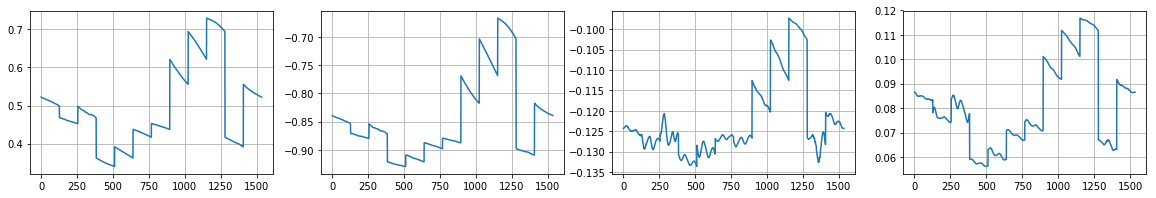

In [5]:
# fig, axes = plt.subplots(2,4)
# fig.set_size_inches(20,6)

# for i,dd in enumerate(train_group[0:1]):
#     print(i,dd)
#     axes[i].plot(train_X[train_group == dd][:,:,i].reshape(-1))
#     axes[i].grid(True)

fig, axes = plt.subplots(1,4)
fig.set_size_inches(20,3)

for i in range(4):
    axes[i].plot(train_X[train_group == 17][:,:,i].reshape(-1))
    axes[i].grid(True)

In [6]:
def sq_dist(a,b):
    ''' the squared euclidean distance between two samples '''
    
    return np.sum((a-b)**2, axis=1)


def find_run_edges(data, edge):
    ''' examine links between samples. left/right run edges are those samples which do not have a link on that side. '''

    if edge == 'left':
        border1 = 0 #取128的第1个点
        border2 = -1#取128的最后1个点
    elif edge == 'right':
        border1 = -1
        border2 = 0
    else:
        return False
    
    edge_list = []
    linked_list = []
    
    for i in range(len(data)):
        dist_list = sq_dist(data[i, border1, :4], data[:, border2, :4]) # distances to rest of samples(包括3810个sample的距离)
#         print('dist_list:',len(dist_list),dist_list)
        min_dist = np.min(dist_list)
        closest_i   = np.argmin(dist_list) # this is i's closest neighbor
        if closest_i == i: # this might happen and it's definitely wrong
            print('Sample', i, 'linked with itself. Next closest sample used instead.')
            closest_i = np.argsort(dist_list)[1]
        dist_list = sq_dist(data[closest_i, border2, :4], data[:, border1, :4]) # now find closest_i's closest neighbor
        rev_dist = np.min(dist_list)
        closest_rev = np.argmin(dist_list) # here it is
        if closest_rev == closest_i: # again a check
            print('Sample', i, '(back-)linked with itself. Next closest sample used instead.')
            closest_rev = np.argsort(dist_list)[1]
        if (i != closest_rev): # we found an edge
            edge_list.append(i)
        else:
            linked_list.append([i, closest_i, min_dist])
            
    return edge_list, linked_list


def find_runs(data, left_edges, right_edges):
    ''' go through the list of samples & link the closest neighbors into a single run '''
    
    data_runs = []

    for start_point in left_edges:
        i = start_point
        run_list = [i]
        while i not in right_edges:
            tmp = np.argmin(sq_dist(data[i, -1, :4], data[:, 0, :4]))
            if tmp == i: # self-linked sample
                tmp = np.argsort(sq_dist(data[i, -1, :4], data[:, 0, :4]))[1]
            i = tmp
            run_list.append(i)
        data_runs.append(np.array(run_list))
    
    return data_runs

In [7]:
train_left_edges, train_left_linked  = find_run_edges(train_X, edge='left')
train_right_edges, train_right_linked = find_run_edges(train_X, edge='right')
print(np.array(train_left_edges).shape,np.array(train_left_linked).shape,train_left_edges[0],train_left_linked[0])
print(np.array(train_right_edges).shape,np.array(train_right_linked).shape,train_right_edges[0],train_right_linked[0])
print('Found', len(train_left_edges), 'left edges and', len(train_right_edges), 'right edges.')

Sample 1 (back-)linked with itself. Next closest sample used instead.
Sample 216 linked with itself. Next closest sample used instead.
Sample 335 linked with itself. Next closest sample used instead.
Sample 748 (back-)linked with itself. Next closest sample used instead.
Sample 799 linked with itself. Next closest sample used instead.
Sample 1205 linked with itself. Next closest sample used instead.
Sample 1913 linked with itself. Next closest sample used instead.
Sample 1986 linked with itself. Next closest sample used instead.
Sample 2555 linked with itself. Next closest sample used instead.
Sample 2612 linked with itself. Next closest sample used instead.
Sample 2761 linked with itself. Next closest sample used instead.
Sample 2917 linked with itself. Next closest sample used instead.
Sample 3312 linked with itself. Next closest sample used instead.
Sample 181 linked with itself. Next closest sample used instead.
Sample 272 linked with itself. Next closest sample used instead.
Sampl

In [8]:
train_runs = find_runs(train_X, train_left_edges, train_right_edges)
# len(train_runs)
# train_runs.

Have we found all samples? Have we used any sample twice? The answer is yes, and no. Perfect.

In [9]:
flat_list = [series_id for run in train_runs for series_id in run]
print(len(flat_list), len(np.unique(flat_list)))

3810 3810


Now for the real test. How many different surfaces are in each run? Only 4 runs have more than one surface (and if you look at them, you can easily split them by hand). This actually works!

In [10]:
print([ len(np.unique(train_y[run])) for run in train_runs ])

[1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1]


In [11]:
#返回surface不一样的runs
train_not_unique=np.array([len(np.unique(train_y[run])) for run in train_runs ])
index_train_not_unique=np.where(train_not_unique>1)
index_train_not_unique

(array([ 7, 52, 59, 71], dtype=int64),)

In [12]:
# for index in list(index_train_not_unique):
#     for i in index
#     print('**************')
#     print(i,pd.Series(train_y[i]).value_counts())
train_y[train_runs[7]]

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8], dtype=int64)

In [13]:
train_runs[7]

array([ 327,  818,  266,  503, 1366, 1451,  184,  784, 1081,  604,  283,
        367, 1477,  951,  286,  228, 1561,  986,  755,  456,  676, 1168,
        881, 1332, 1613,  948,  952, 1544,  574,  109, 1322, 1036,  211,
        130,  629, 1570,  768,  925,  337, 1687,  482,  123, 1066,  821,
        974,  328, 1548,  172,  355,  957, 1481, 1046, 1650,  857,  724,
        164, 1092, 1017, 1300, 1212,  536,  531, 1032,  994, 1501,  588,
        579, 1177,  812, 1333, 1253], dtype=int64)

In [14]:
np.where(train_y[train_runs[7]]==8)

(array([43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
        60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70], dtype=int64),)

In [15]:
train_y[train_runs[52]]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1], dtype=int64)

In [16]:
np.where(train_y[train_runs[52]]==1)

(array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
       dtype=int64),)

In [17]:
train_y[train_runs[59]]

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [18]:
np.where(train_y[train_runs[59]]==1)

(array([ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143],
       dtype=int64),)

In [19]:
train_y[train_runs[71]]

array([0, 0, 0, 0, 0, 0, 8, 8], dtype=int64)

In [20]:
np.where(train_y[train_runs[71]]==8)

(array([6, 7], dtype=int64),)

In [21]:
train_runs.append(train_runs[7][43:71])
train_runs[7]=np.delete(train_runs[7],list(np.arange(43,71,1)),0)
train_runs.append(train_runs[52][9:23])
train_runs[52]=np.delete(train_runs[52],list(np.arange(9,23,1)),0)
train_runs.append(train_runs[59][80:144])
train_runs[59]=np.delete(train_runs[59],list(np.arange(80,144,1)),0)
train_runs.append(train_runs[71][6:8])
train_runs[71]=np.delete(train_runs[71],list(np.arange(6,8,1)),0)

手动拆开不止1种surface的run，拆开后没有两种surface的run了

In [22]:
print([ len(np.unique(train_y[run])) for run in train_runs ])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Interesting. Some runs contain 2, 3 and even 4 groups. So several groups were cut from one run:

In [23]:
print([ len(np.unique(train_group[run])) for run in train_runs ])

[2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1]


Let's plot all 10 channels for one run. Beautiful.

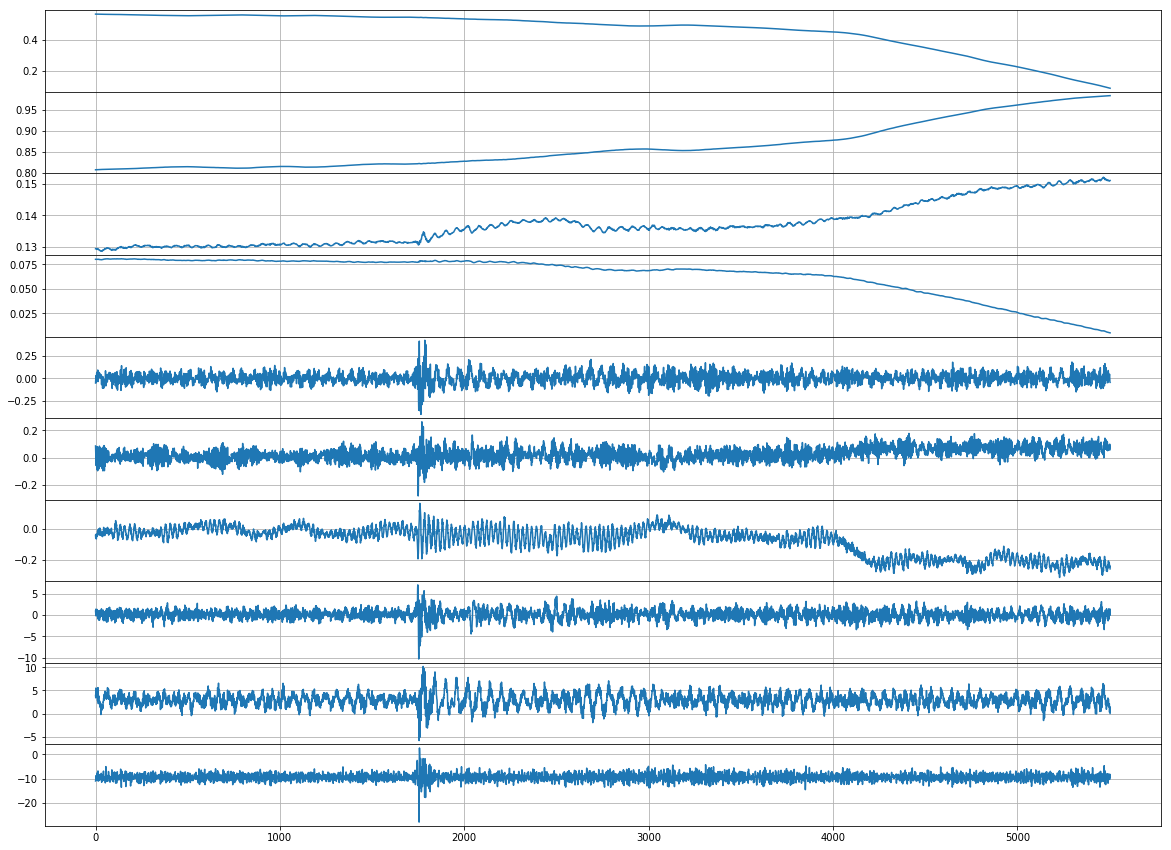

In [24]:
fig, axes = plt.subplots(10,1, sharex=True)
fig.set_size_inches(20,15)
fig.subplots_adjust(hspace=0)

for i in range(10):
    axes[i].plot(train_X[train_runs[7]][:,:,i].reshape(-1))
    axes[i].grid(True)

Let's add our new knowledge to train_y. Now you can use this info to train your models to even greater perfection. Enjoy!

In [25]:
df_train_y['run_id'] = 0
df_train_y['run_pos'] = 0

for run_id in range(len(train_runs)):
    for run_pos in range(len(train_runs[run_id])):
        series_id = train_runs[run_id][run_pos]
        df_train_y.at[ series_id, 'run_id'  ] = run_id
        df_train_y.at[ series_id, 'run_pos' ] = run_pos

df_train_y.to_csv('.\\Kaggle\\CareerCon 2019 - Help Navigate Robots\\data\\y_train_with_runs.csv', index=False)
df_train_y.tail()

,series_id,group_id,surface,run_id,run_pos
3805,3805,55,tiled,46,4
3806,3806,67,wood,74,2
3807,3807,48,fine_concrete,65,57
3808,3808,54,tiled,54,97
3809,3809,56,soft_pvc,69,123


...But wait. Might this also work with the test data?

In [60]:
test_left_edges, test_left_linked  = find_run_edges(test_X, edge='left')
test_right_edges, test_right_linked = find_run_edges(test_X, edge='right')
print('Found', len(test_left_edges), 'left edges and', len(test_right_edges), 'right edges.')

Sample 355 linked with itself. Next closest sample used instead.
Sample 580 linked with itself. Next closest sample used instead.
Sample 1402 linked with itself. Next closest sample used instead.
Sample 1547 linked with itself. Next closest sample used instead.
Sample 1716 linked with itself. Next closest sample used instead.
Sample 2136 (back-)linked with itself. Next closest sample used instead.
Sample 2474 linked with itself. Next closest sample used instead.
Sample 2495 (back-)linked with itself. Next closest sample used instead.
Sample 2600 linked with itself. Next closest sample used instead.
Sample 2922 linked with itself. Next closest sample used instead.
Sample 580 linked with itself. Next closest sample used instead.
Sample 1216 linked with itself. Next closest sample used instead.
Sample 1409 linked with itself. Next closest sample used instead.
Sample 1410 linked with itself. Next closest sample used instead.
Sample 1670 linked with itself. Next closest sample used instead.

In [71]:
test_runs = find_runs(test_X, test_left_edges, test_right_edges)

In [72]:
test_runs

[array([  45,  619,  814, 1598, 1945,  480,  695, 1279,  621, 1648,   51,
        2170, 2096, 2642, 2160, 2064, 3771, 1111,  884,  390, 2462, 1616,
         628, 2561, 3013, 2149, 2082,  202,  696, 2154, 2358,  816,  883,
        3038, 3238, 3642, 1484, 2676, 3516, 1917, 1404, 2975, 2964, 1636,
        1560, 2647, 1970, 3208, 1568,  646, 2054, 1952, 1630,  273, 1723,
        3269,  357, 3652,  434, 1688, 2897, 1299, 2435, 3112, 3571,  343,
        1615, 2813, 2354, 1828,  216,  521, 2381,  817, 1331, 3166, 1822,
         271, 2520, 1358,  551, 1631, 1147, 3023, 3704, 3218, 3755,  405,
         469,  293, 1575, 2458,  387, 2585,   13, 1415, 2374, 1323,  197,
         826,  828, 3503, 2027, 2953, 1944, 2099, 2658, 1361, 1021, 3620,
        2942, 1070, 2763,  616,  712, 1405, 1781, 1628, 1709, 3089,  722,
        1926, 3398, 2219, 2983, 1371, 3633, 1281, 3237,  565, 1612, 2973,
         985, 3747,  790, 2643, 3591, 3358,  167, 1362, 1176, 3500,  639,
         483, 3595, 3042, 2812, 1184, 

In [73]:
submission_before=pd.read_csv('.\\Kaggle\\CareerCon 2019 - Help Navigate Robots\\data\\Submission-without EulerX 50KFolds.csv')
submission_before.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,tiled
3,3,carpet
4,4,soft_tiles


In [81]:
submission_before['surface']=submission_before['surface'].map(surface_to_numeric)
submission_before.head()

,series_id,surface
0,0,5
1,1,1
2,2,3
3,3,6
4,4,2


In [74]:
test_runs=np.array(pd.DataFrame((test_runs)).replace('\n','')

SyntaxError: unexpected EOF while parsing (<ipython-input-74-c69b6f2f7459>, line 1)

In [76]:
test_runs

[array([  45,  619,  814, 1598, 1945,  480,  695, 1279,  621, 1648,   51,
        2170, 2096, 2642, 2160, 2064, 3771, 1111,  884,  390, 2462, 1616,
         628, 2561, 3013, 2149, 2082,  202,  696, 2154, 2358,  816,  883,
        3038, 3238, 3642, 1484, 2676, 3516, 1917, 1404, 2975, 2964, 1636,
        1560, 2647, 1970, 3208, 1568,  646, 2054, 1952, 1630,  273, 1723,
        3269,  357, 3652,  434, 1688, 2897, 1299, 2435, 3112, 3571,  343,
        1615, 2813, 2354, 1828,  216,  521, 2381,  817, 1331, 3166, 1822,
         271, 2520, 1358,  551, 1631, 1147, 3023, 3704, 3218, 3755,  405,
         469,  293, 1575, 2458,  387, 2585,   13, 1415, 2374, 1323,  197,
         826,  828, 3503, 2027, 2953, 1944, 2099, 2658, 1361, 1021, 3620,
        2942, 1070, 2763,  616,  712, 1405, 1781, 1628, 1709, 3089,  722,
        1926, 3398, 2219, 2983, 1371, 3633, 1281, 3237,  565, 1612, 2973,
         985, 3747,  790, 2643, 3591, 3358,  167, 1362, 1176, 3500,  639,
         483, 3595, 3042, 2812, 1184, 

In [95]:
for i,run in enumerate(test_runs):
    value=np.argmax(submission_before['surface'][list(test_runs[i])].value_counts())
    submission_before['surface'][list(test_runs[i])]=value

In [97]:
submission_before.head()

,series_id,surface
0,0,5
1,1,1
2,2,3
3,3,6
4,4,2


In [96]:
print([ len(np.unique(submission_before['surface'][run])) for run in test_runs ])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [112]:
surface_to_numeric

{'fine_concrete': 0,
 'concrete': 1,
 'soft_tiles': 2,
 'tiled': 3,
 'soft_pvc': 4,
 'hard_tiles_large_space': 5,
 'carpet': 6,
 'hard_tiles': 7,
 'wood': 8}

In [113]:
numeric_to_surface=dict((k,v) for k,v in enumerate(surface_to_numeric))
# for k,v in enumerate(surface_to_numeric):
#     numeric_to_surface=dict(v,k)

In [114]:
numeric_to_surface

{0: 'fine_concrete',
 1: 'concrete',
 2: 'soft_tiles',
 3: 'tiled',
 4: 'soft_pvc',
 5: 'hard_tiles_large_space',
 6: 'carpet',
 7: 'hard_tiles',
 8: 'wood'}

In [115]:
submission_before['surface']=submission_before['surface'].map(numeric_to_surface)

In [116]:
submission_before

,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,tiled
3,3,carpet
4,4,soft_tiles
5,5,concrete
6,6,soft_pvc
7,7,concrete
8,8,wood
9,9,wood


In [117]:
submission_before.to_csv('.\\Kaggle\\CareerCon 2019 - Help Navigate Robots\\data\\submission_before.csv', index=False)

Again no samples are used twice, but we have lost some.

In [28]:
flat_list = [series_id for run in test_runs for series_id in run]
print(len(flat_list), len(np.unique(flat_list)))

3790 3790


3816 - 3790 = 26 samples are not in any run and aren't edges. They must form a closed ring -> another run. find it:

In [29]:
lost_samples = np.array([ i for i in range(len(test_X)) if i not in np.concatenate(test_runs) ])
print(lost_samples)
print(len(lost_samples))

[ 264  361  529  620  733  954 1148 1248 1432 1534 1570 1738 1739 2090
 2205 2714 2847 2978 2991 3115 3173 3183 3195 3359 3517 3655]
26


In [30]:
find_run_edges(test_X[lost_samples], edge='left')[1][0]

[0, 5, 2.0548399999999954e-07]

In [31]:
lost_run = np.array(lost_samples[find_runs(test_X[lost_samples], [0], [5])[0]])
test_runs.append(lost_run)

In [32]:
np.array(test_runs).shape

(76,)

Perfect. Now we also have test runs. A nice plot to prove it:

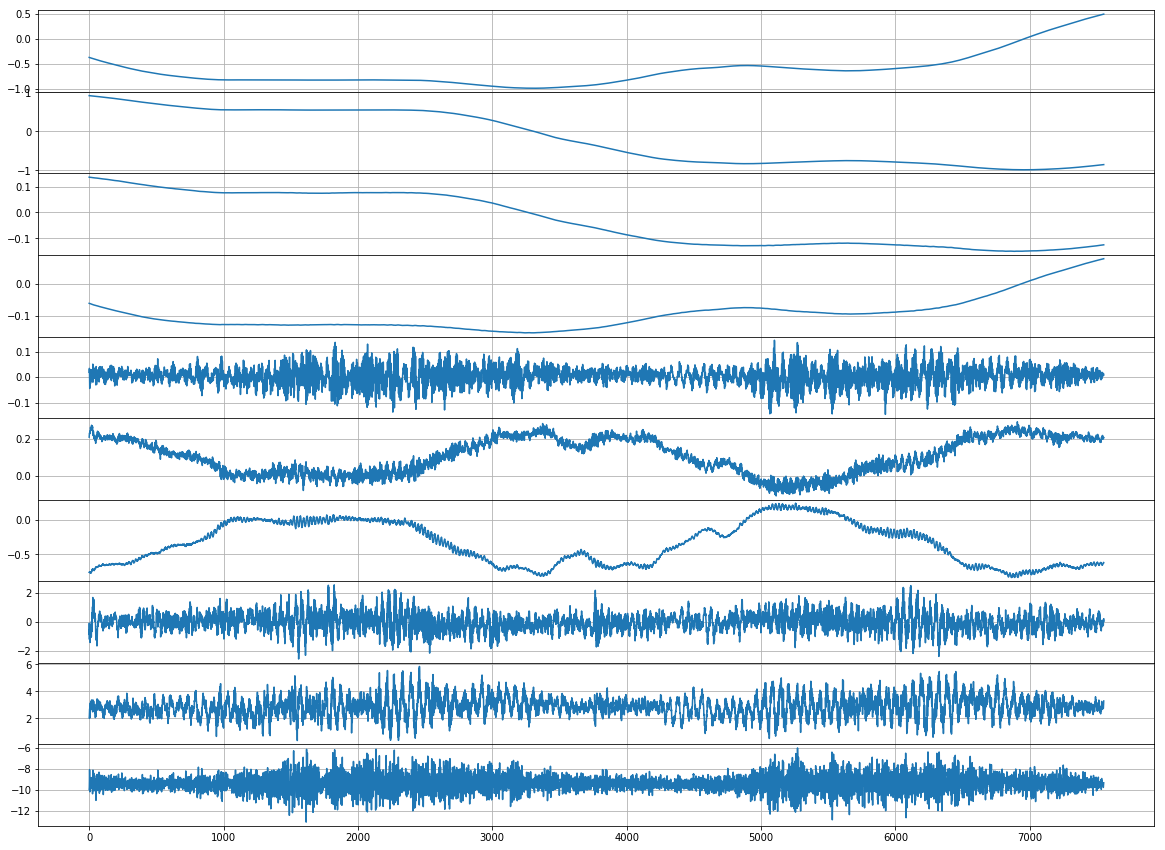

In [33]:
fig, axes = plt.subplots(10,1, sharex=True)
fig.set_size_inches(20,15)
fig.subplots_adjust(hspace=0)

for i in range(10):
    axes[i].plot(test_X[test_runs[1]][:,:,i].reshape(-1))
    axes[i].grid(True)

I'll leave you with a caution and an exercise: First, there are certainly some errors in the test runs. Two runs with different surfaces might have been stitched into one (as happened 4 times with the train data) by chance. Second, might it even be possible to link across train and test? Well, see for yourself...

In [42]:
list(test_runs)

[array([  45,  619,  814, 1598, 1945,  480,  695, 1279,  621, 1648,   51,
        2170, 2096, 2642, 2160, 2064, 3771, 1111,  884,  390, 2462, 1616,
         628, 2561, 3013, 2149, 2082,  202,  696, 2154, 2358,  816,  883,
        3038, 3238, 3642, 1484, 2676, 3516, 1917, 1404, 2975, 2964, 1636,
        1560, 2647, 1970, 3208, 1568,  646, 2054, 1952, 1630,  273, 1723,
        3269,  357, 3652,  434, 1688, 2897, 1299, 2435, 3112, 3571,  343,
        1615, 2813, 2354, 1828,  216,  521, 2381,  817, 1331, 3166, 1822,
         271, 2520, 1358,  551, 1631, 1147, 3023, 3704, 3218, 3755,  405,
         469,  293, 1575, 2458,  387, 2585,   13, 1415, 2374, 1323,  197,
         826,  828, 3503, 2027, 2953, 1944, 2099, 2658, 1361, 1021, 3620,
        2942, 1070, 2763,  616,  712, 1405, 1781, 1628, 1709, 3089,  722,
        1926, 3398, 2219, 2983, 1371, 3633, 1281, 3237,  565, 1612, 2973,
         985, 3747,  790, 2643, 3591, 3358,  167, 1362, 1176, 3500,  639,
         483, 3595, 3042, 2812, 1184, 

In [50]:
submission_before=pd.read_csv('.\\Kaggle\\CareerCon 2019 - Help Navigate Robots\\data\\Submission-without EulerX 50KFolds.csv')
submission_before.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,tiled
3,3,carpet
4,4,soft_tiles


In [52]:
print('Convert to numbers: ', surface_to_numeric)

Convert to numbers:  {'fine_concrete': 0, 'concrete': 1, 'soft_tiles': 2, 'tiled': 3, 'soft_pvc': 4, 'hard_tiles_large_space': 5, 'carpet': 6, 'hard_tiles': 7, 'wood': 8}


In [51]:
submission_before['surface']=submission_before['surface'].map(surface_to_numeric)
submission_before.head()

,series_id,surface
0,0,5
1,1,1
2,2,3
3,3,6
4,4,2


In [43]:
print([ len(np.unique(submission_before[list(run)])) for run in test_runs ])

KeyError: '[  45  619  814 1598 1945  480  695 1279  621 1648   51 2170 2096 2642\n 2160 2064 3771 1111  884  390 2462 1616  628 2561 3013 2149 2082  202\n  696 2154 2358  816  883 3038 3238 3642 1484 2676 3516 1917 1404 2975\n 2964 1636 1560 2647 1970 3208 1568  646 2054 1952 1630  273 1723 3269\n  357 3652  434 1688 2897 1299 2435 3112 3571  343 1615 2813 2354 1828\n  216  521 2381  817 1331 3166 1822  271 2520 1358  551 1631 1147 3023\n 3704 3218 3755  405  469  293 1575 2458  387 2585   13 1415 2374 1323\n  197  826  828 3503 2027 2953 1944 2099 2658 1361 1021 3620 2942 1070\n 2763  616  712 1405 1781 1628 1709 3089  722 1926 3398 2219 2983 1371\n 3633 1281 3237  565 1612 2973  985 3747  790 2643 3591 3358  167 1362\n 1176 3500  639  483 3595 3042 2812 1184 1903 2235 3796 2444  380 2343\n 2755 3636  474 1322 1446 2476 2736  832] not in index'

In [40]:
for run in test_runs[0:2]:
    print(run)
    print(submission_before[list(run)])

[  45  619  814 1598 1945  480  695 1279  621 1648   51 2170 2096 2642
 2160 2064 3771 1111  884  390 2462 1616  628 2561 3013 2149 2082  202
  696 2154 2358  816  883 3038 3238 3642 1484 2676 3516 1917 1404 2975
 2964 1636 1560 2647 1970 3208 1568  646 2054 1952 1630  273 1723 3269
  357 3652  434 1688 2897 1299 2435 3112 3571  343 1615 2813 2354 1828
  216  521 2381  817 1331 3166 1822  271 2520 1358  551 1631 1147 3023
 3704 3218 3755  405  469  293 1575 2458  387 2585   13 1415 2374 1323
  197  826  828 3503 2027 2953 1944 2099 2658 1361 1021 3620 2942 1070
 2763  616  712 1405 1781 1628 1709 3089  722 1926 3398 2219 2983 1371
 3633 1281 3237  565 1612 2973  985 3747  790 2643 3591 3358  167 1362
 1176 3500  639  483 3595 3042 2812 1184 1903 2235 3796 2444  380 2343
 2755 3636  474 1322 1446 2476 2736  832]


KeyError: '[  45  619  814 1598 1945  480  695 1279  621 1648   51 2170 2096 2642\n 2160 2064 3771 1111  884  390 2462 1616  628 2561 3013 2149 2082  202\n  696 2154 2358  816  883 3038 3238 3642 1484 2676 3516 1917 1404 2975\n 2964 1636 1560 2647 1970 3208 1568  646 2054 1952 1630  273 1723 3269\n  357 3652  434 1688 2897 1299 2435 3112 3571  343 1615 2813 2354 1828\n  216  521 2381  817 1331 3166 1822  271 2520 1358  551 1631 1147 3023\n 3704 3218 3755  405  469  293 1575 2458  387 2585   13 1415 2374 1323\n  197  826  828 3503 2027 2953 1944 2099 2658 1361 1021 3620 2942 1070\n 2763  616  712 1405 1781 1628 1709 3089  722 1926 3398 2219 2983 1371\n 3633 1281 3237  565 1612 2973  985 3747  790 2643 3591 3358  167 1362\n 1176 3500  639  483 3595 3042 2812 1184 1903 2235 3796 2444  380 2343\n 2755 3636  474 1322 1446 2476 2736  832] not in index'